## Load Estonian weather service

- https://www.ilmateenistus.ee/teenused/ilmainfo/ilmatikker/

In [2]:
import requests
import datetime
import xml.etree.ElementTree as ET

import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import geopandas as gpd
import fiona
from fiona.crs import from_epsg


import numpy as np
from shapely.geometry import Point

import matplotlib.pyplot as plt

%matplotlib inline

req = requests.get("http://www.ilmateenistus.ee/ilma_andmed/xml/observations.php")

print(req.encoding)
print(req.headers['content-type'])

tree = ET.fromstring(req.content.decode(req.encoding) )

print(tree.tag)
print(tree.attrib)

ts = tree.attrib['timestamp']
print(datetime.datetime.fromtimestamp(int(ts)))

ISO-8859-1
text/xml
observations
{'timestamp': '1590429078'}
2020-05-25 20:51:18


104


,stations,wmocode,precipitations,airtemperature,windspeed,waterlevel,watertemperature,geometry
0,Kuressaare linn,None,NaN,15.5,NaN,NaN,NaN,POINT (22.48944444411111 58.26416666666667)
1,Tallinn-Harku,26038,0.0,14.3,0.8,NaN,NaN,POINT (24.60289166662428 59.39812222235513)
2,Pakri,26029,0.0,11.8,3.3,NaN,NaN,POINT (24.04008055547654 59.38950277719013)
3,Kunda,26045,NaN,NaN,2.9,NaN,9.9,POINT (26.54139722207962 59.52141111042325)
4,Jõhvi,26046,0.0,13.0,2.1,NaN,NaN,POINT (27.39827499992098 59.32902499979958)


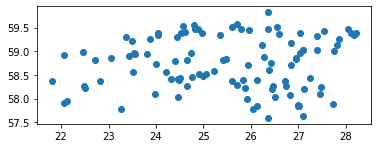

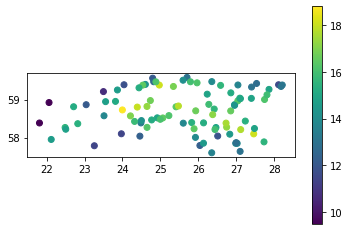

In [3]:
data = {'stations' : [],
        'wmocode': [],
        'precipitations': [],
        'airtemperature': [],
        'windspeed': [],
        'waterlevel': [],
        'watertemperature': [],
        'geometry': []
       }


counter = 0
for station in tree.findall('station'):
    counter += 1
    
    # print(station.tag, child.attrib)
    
    # < name > Virtsu < /name > – jaama nimi.
    name = station.find('name').text
    data['stations'].append(name)
    # < wmocode > 26128 < /wmocode > – jaama WMO kood.
    wmocode = station.find('wmocode').text
    data['wmocode'].append(wmocode)
    
    try:
    # < longitude > 23.51355555534363 < /longitude > – jaama asukoha koordinaat.
        lon = station.find('longitude').text
        # < latitude > 58.572674999100215 < /latitude > – jaama asukoha koordinaat.
        lat = station.find('latitude').text
        coords = Point(float(lon), float(lat))
        data['geometry'].append(coords)
    except ValueError as ve:
        pass
    
    # < phenomenon > Light snowfall < /phenomenon > – jaamas esinev ilmastikunähtus, selle puudumisel pilvisuse aste (kui jaamas tehakse manuaalseid pilvisuse mõõtmisi). Täielik nimekiri nähtustest on allpool olevas tabelis.
    # < visibility > 34.0 < /visibility > – nähtavus (km).
    # < precipitations > 0 < /precipitations > – sademed (mm) viimase tunni jooksul. Lume, lörtsi, rahe ja teiste taoliste sademete hulk on samuti esitatud vee millimeetritena. 1 cm lund ~ 1 mm vett.
    precip = station.find('precipitations').text
    data['precipitations'].append(precip)
    # < airpressure > 1005.4 < /airpressure > – õhurõhk (hPa). Normaalrõhk on 1013.25 hPa.
    # < relativehumidity > 57 < /relativehumidity > – suhteline õhuniiskus (%).
    # < airtemperature > -3.6 < /airtemperature > – õhutemperatuur (°C).
    temp = station.find('airtemperature').text
    data['airtemperature'].append(temp)
    # < winddirection > 101 < /winddirection > – tuule suund (°).
    # < windspeed > 3.2 < /windspeed > – keskmine tuule kiirus (m/s).
    wind = station.find('windspeed').text
    data['windspeed'].append(wind)
    # < windspeedmax > 5.1 < /windspeedmax > – maksimaalne tuule kiirus ehk puhangud (m/s).
    # < waterlevel > -49 < /waterlevel > – veetase (cm Kroonlinna nulli suhtes)
    waterlevel  = station.find('waterlevel').text
    data['waterlevel'].append(waterlevel)
    # < waterlevel_eh2000 > -28 < waterlevel_eh2000/ > – veetase (cm Amsterdami nulli suhtes)
    # waterlevel_eh2000 = station.find('waterlevel_eh2000').text
    # < watertemperature > -0.2 < /watertemperature > – veetemperatuur (°C)
    watertemp = station.find('watertemperature').text
    data['watertemperature'].append(watertemp)

print(counter)

df = pd.DataFrame(data)

for field in ['precipitations','airtemperature','windspeed','waterlevel','watertemperature']:
    if field in df.columns:
        if is_string_dtype(df[field]):
            df[field] = df[field].astype(float)
                
display(df.head(5))

geo_df = gpd.GeoDataFrame(df, crs=from_epsg(4326), geometry='geometry')

geo_df.plot()

air_df = geo_df.dropna(subset=['airtemperature'])

air_df.plot(column='airtemperature', legend=True)

In [4]:
geo_df_3301 = geo_df.dropna(subset=['airtemperature']).to_crs(epsg=3301)
geo_df_3301['x'] = geo_df_3301['geometry'].apply(lambda p: p.x)
geo_df_3301['y'] = geo_df_3301['geometry'].apply(lambda p: p.y)
display(geo_df_3301.head(5))

geo_df_3301.to_file('ilmateenistus_airtemp_stations.shp', encoding='utf-8')

,stations,wmocode,precipitations,airtemperature,windspeed,waterlevel,watertemperature,geometry,x,y
0,Kuressaare linn,None,NaN,15.5,NaN,NaN,NaN,POINT (411346.597 6459155.342),411346.597496,6.459155e+06
1,Tallinn-Harku,26038,0.0,14.3,0.8,NaN,NaN,POINT (534250.544 6584618.823),534250.544367,6.584619e+06
2,Pakri,26029,0.0,11.8,3.3,NaN,NaN,POINT (502277.599 6583505.345),502277.598516,6.583505e+06
4,Jõhvi,26046,0.0,13.0,2.1,NaN,NaN,POINT (693367.350 6581666.569),693367.350112,6.581667e+06
5,Narva,26058,0.0,11.6,2.5,NaN,NaN,POINT (733368.817 6590658.086),733368.817250,6.590658e+06


## IDW in Python from scratch blogpost

https://www.geodose.com/2019/09/creating-idw-interpolation-from-scratch-python.html

- IDW Algorithm Implementation in Python

  - IDW Interpolation Algorithm Based on Block Radius Sampling Point
  - IDW Interpolation based on Minimum Number of Sampling Point

In [5]:
geo_df_3301.dtypes

stations              object
wmocode               object
precipitations       float64
airtemperature       float64
windspeed            float64
waterlevel           float64
watertemperature     float64
geometry            geometry
x                    float64
y                    float64
dtype: object

In [6]:
from idw_basic import idw_rblock, idw_npoint

In [7]:
x_idw_list1, y_idw_list1, z_head1 = idw_rblock(x=geo_df_3301['x'].astype(float).values.tolist(),
                                            y=geo_df_3301['y'].astype(float).values.tolist(),
                                            z=geo_df_3301['airtemperature'].values.tolist(),
                                            grid_side_length=200,
                                            search_radius=50000,
                                            p=1.5)
display(len(x_idw_list1))
display(len(y_idw_list1))
display(len(z_head1))
display(np.array(z_head1).shape)

c:\dev\build\py_interpol_demo\idw_basic.py:46: RuntimeWarning: invalid value encountered in double_scalars
  z_idw=np.dot(z_block,wt)/sum(w_list) # idw calculation using dot product


200

200

200

(200, 200)

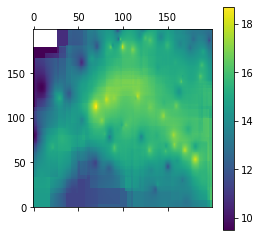

In [8]:
plt.matshow(z_head1, origin='lower')
plt.colorbar()
plt.show()

_idw_npoint_ might take very long, due to ierative search radius increase to find at least n nearest neighbours

In [ ]:
x_idw_list2, y_idw_list2, z_head2 = idw_npoint(x=geo_df_3301['x'].astype(float).values.tolist(),
                                            y=geo_df_3301['y'].astype(float).values.tolist(),
                                            z=geo_df_3301['airtemperature'].values.tolist(),
                                            grid_side_length=100,
                                            n_points=3,
                                            p=1.5,
                                              rblock_iter_distance=50000)
display(len(x_idw_list2))
display(len(y_idw_list2))
display(len(z_head2))
display(np.array(z_head2).shape)

In [ ]:
plt.matshow(z_head2, origin='lower')
plt.colorbar()
plt.show()

## Inverse distance weighting (IDW) in Python with a KDTree

By Copyright (C) 2016 Paul Brodersen <paulbrodersen+idw@gmail.com> under GPL-3.0

code: https://github.com/paulbrodersen/inverse_distance_weighting

Inverse distance weighting is an interpolation method that computes the score of query points based on the scores of their k-nearest neighbours, weighted by the inverse of their distances.

As each query point is evaluated using the same number of data points, this method allows for strong gradient changes in regions of high sample density while imposing smoothness in data sparse regions.

uses:

- numpy
- scipy.spatial (for cKDTree)

In [9]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import idw_knn

In [10]:
XY_obs_coords = np.vstack([geo_df_3301['x'].values, geo_df_3301['y'].values]).T
z_arr = geo_df_3301['airtemperature'].values

display(XY_obs_coords.shape)
display(z_arr.shape)

# returns a function that is trained (the tree setup) for the interpolation on the grid
idw_tree = idw_knn.tree(XY_obs_coords, z_arr)

(92, 2)

(92,)

In [11]:
all_dist_m = geo_df_3301['x'].max() - geo_df_3301['x'].min()
dist_km_x = all_dist_m / 1000
display(dist_km_x)

all_dist_m_y = geo_df_3301['y'].max() - geo_df_3301['y'].min()
dist_km_y = all_dist_m_y / 1000
display(dist_km_y)

366.7757714379732

219.85687205510027

In [12]:
# prepare grids
# number of target interpolation grid shape along x and y axis, e.g. 150*100 raster pixels
nx=int(dist_km_x)
ny=int(dist_km_y)

# preparing the "output" grid
x_spacing = np.linspace(geo_df_3301['x'].min(), geo_df_3301['x'].max(), nx)
y_spacing = np.linspace(geo_df_3301['y'].min(), geo_df_3301['y'].max(), ny)

In [13]:
# preparing the target grid
x_y_grid_pairs = np.meshgrid(x_spacing, y_spacing)

x_y_grid_pairs_list = np.reshape(x_y_grid_pairs, (2, -1)).T

display(f"x_y_grid_pairs {len(x_y_grid_pairs)}")
display(f"x_y_grid_pairs_list reshaped {x_y_grid_pairs_list.shape}")

'x_y_grid_pairs 2'

'x_y_grid_pairs_list reshaped (80154, 2)'

In [14]:
# now interpolating onto the target grid
z_arr_interp = idw_tree(x_y_grid_pairs_list)

display(f"z_arr_interp {z_arr_interp.shape}")

'z_arr_interp (80154,)'

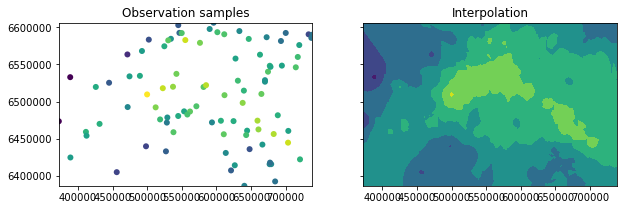

In [15]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

ax1.scatter(XY_obs_coords[:,0], XY_obs_coords[:,1], c=geo_df_3301['airtemperature'], linewidths=0)
ax1.set_title('Observation samples')
ax2.contourf(x_spacing, y_spacing, z_arr_interp.reshape((ny,nx)))
ax2.set_title('Interpolation')
plt.show()

In [16]:
z_arr_interp.shape

(80154,)

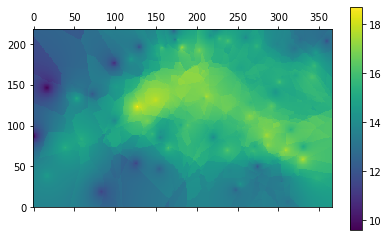

In [17]:
plt.matshow(z_arr_interp.reshape((ny,nx)), origin='lower')
plt.colorbar()
plt.show()

In [18]:
display(f"x_spacing {x_spacing.shape}")
display(f"y_spacing {y_spacing.shape}")

# is a x_y_grid_pair a list of two ndarrays, each is fully spatial 100x150 fields, one holds the x coords the other the y coords
x_mg = np.meshgrid(x_spacing, y_spacing)

display(f"x_mg {type(x_mg)} {len(x_mg)} len0 {type(x_mg[0])} {len(x_mg[0])} {x_mg[0].shape} len1 {type(x_mg[1])} {len(x_mg[1])} {x_mg[0].shape}")

# the yget reshaped into two long flattened arrays the joint full list of target x y pairs representing all grid locations
x_mg_interp_prep = np.reshape(x_mg, (2, -1)).T

display(f"x_mg_interp_prep {type(x_mg_interp_prep)} {len(x_mg_interp_prep)} {x_mg_interp_prep.shape}")


'x_spacing (366,)'

'y_spacing (219,)'

"x_mg <class 'list'> 2 len0 <class 'numpy.ndarray'> 219 (219, 366) len1 <class 'numpy.ndarray'> 219 (219, 366)"

"x_mg_interp_prep <class 'numpy.ndarray'> 80154 (80154, 2)"

## Interpolation in Python with Radial Basis Function 

- https://stackoverflow.com/a/3114117

In [19]:
from scipy.interpolate import Rbf

def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)


def plot(x,y,z,grid):
    plt.figure()
    grid_flipped = np.flipud(grid)
    plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
    # plt.hold(True)
    plt.scatter(x,y,c=z)
    plt.colorbar()

In [20]:
# nx, ny = 50, 50

x=geo_df_3301['x'].astype(float).values
y=geo_df_3301['y'].astype(float).values
z=geo_df_3301['airtemperature'].values

xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

grid2 = scipy_idw(x,y,z,xi,yi)
grid2 = grid2.reshape((ny, nx))

Text(0.5, 1.0, "Scipy's Rbf with function=linear")

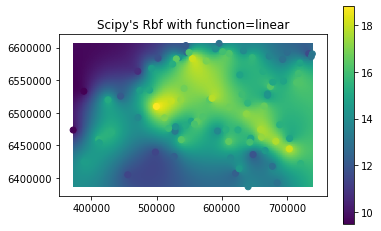

In [21]:
plot(x,y,z,grid2)
plt.title("Scipy's Rbf with function=linear")

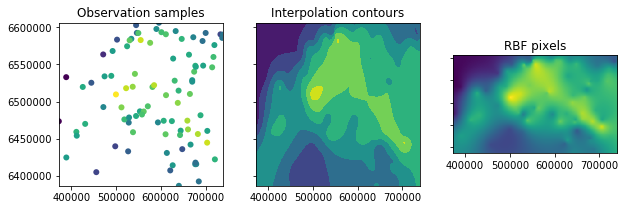

In [22]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,3))

ax1.scatter(x,y, c=z, linewidths=0)
ax1.set_title('Observation samples')
ax2.contourf(np.linspace(x.min(), x.max(), nx), np.linspace(y.min(), y.max(), ny), grid2)
ax2.set_title('Interpolation contours')

ax3.imshow(np.flipud(grid2), extent=(x.min(), x.max(), y.min(), y.max()))
ax3.set_title('RBF pixels')

plt.show()

## Kriging with PyKrige

- https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 1.569019116952719e-05
Nugget: 1.6028482982575212 



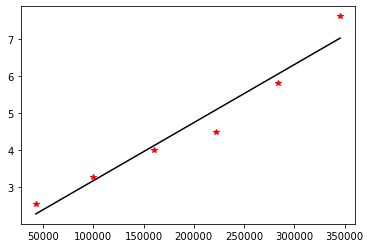

Calculating statistics on variogram model fit...


In [23]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(geo_df_3301['x'].astype(float).values,
                     geo_df_3301['y'].astype(float).values,
                     geo_df_3301['airtemperature'].values,
                     variogram_model='linear',
                     verbose=True,
                     enable_plotting=True)

In [24]:
z, ss = OK.execute('grid', x_spacing, y_spacing)

Executing Ordinary Kriging...



In [25]:
display(z.shape)
display(ss.shape)

(219, 366)

(219, 366)

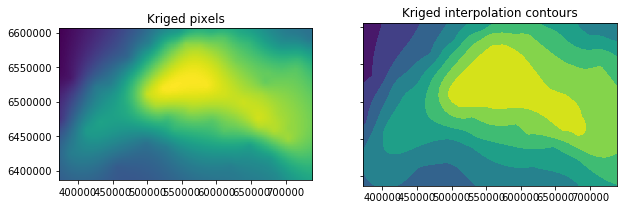

In [26]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

ax1.imshow(np.flipud(z), extent=(x.min(), x.max(), y.min(), y.max()))
ax1.set_title('Kriged pixels')

ax2.contourf(np.linspace(x.min(), x.max(), nx), np.linspace(y.min(), y.max(), ny), z)
ax2.set_title('Kriged interpolation contours')


plt.show()

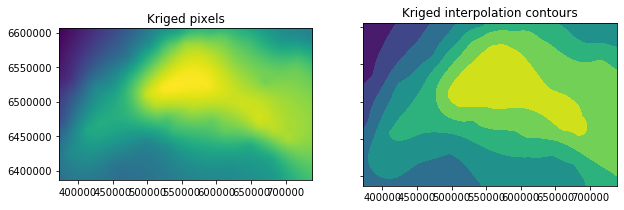

In [27]:
from pykrige.uk import UniversalKriging

UK = UniversalKriging(geo_df_3301['x'].astype(float).values,
                      geo_df_3301['y'].astype(float).values,
                      geo_df_3301['airtemperature'].values,
                      variogram_model='linear',
                      drift_terms=['regional_linear'])

z2, ss2 = UK.execute('grid', x_spacing, y_spacing)


# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

ax1.imshow(np.flipud(z2), extent=(x.min(), x.max(), y.min(), y.max()))
ax1.set_title('Kriged pixels')

ax2.contourf(np.linspace(x.min(), x.max(), nx), np.linspace(y.min(), y.max(), ny), z2)
ax2.set_title('Kriged interpolation contours')

plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 1.569019116952719e-05
Nugget: 1.6028482982575212 



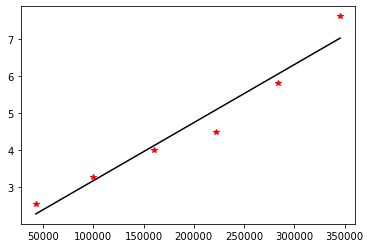

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



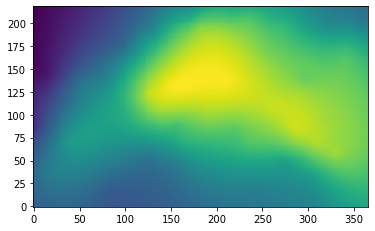

In [34]:
from gstools import Gaussian

# a GSTools based covariance model
cov_model = Gaussian(dim=2, len_scale=1, anis=0.2, angles=-0.5, var=0.5, nugget=0.1)

# ordinary kriging with pykrige
OK_cov = OrdinaryKriging(geo_df_3301['x'].astype(float).values,
                     geo_df_3301['y'].astype(float).values,
                     geo_df_3301['airtemperature'].values,
                     # variogram_model='gaussian',
                     variogram_function=cov_model,
                     verbose=True,
                     enable_plotting=True)


z1_cov, ss1_cov = OK_cov.execute('grid', x_spacing, y_spacing)
plt.imshow(z1_cov, origin="lower")
plt.show()

## surface/contour/mesh plotting of interpolated grids

https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/pcolormesh_levels.html#sphx-glr-gallery-images-contours-and-fields-pcolormesh-levels-py

In [22]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

In [23]:
nbins=15

levels = MaxNLocator(nbins=nbins).tick_values(z_arr_interp.min(), z_arr_interp.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('viridis')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

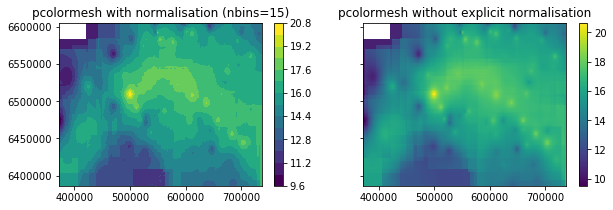

In [24]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

im = ax1.pcolormesh(x_idw_list1, y_idw_list1, np.array(z_head1), cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax1)
ax1.set_title('pcolormesh with normalisation (nbins={})'.format(nbins))

im2 = ax2.pcolormesh(x_idw_list1, y_idw_list1, np.array(z_head1), cmap=cm.viridis)
fig.colorbar(im2, ax=ax2)
ax2.set_title('pcolormesh without explicit normalisation')
plt.show()

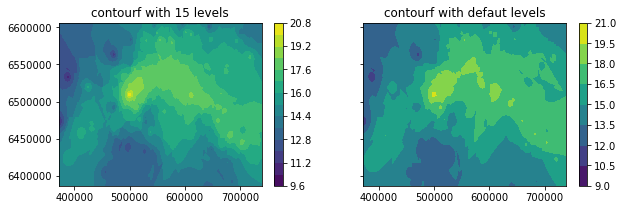

In [25]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

cf = ax1.contourf(x_spacing, y_spacing, z_arr_interp.reshape((ny,nx)), levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with {} levels'.format(nbins))

cf2 = ax2.contourf(x_spacing, y_spacing, z_arr_interp.reshape((ny,nx)), cmap=cm.viridis)
fig.colorbar(cf2, ax=ax2)
ax2.set_title('contourf with defaut levels')
plt.show()

In [26]:
z_arr_interp.reshape((ny,nx)).shape

(219, 366)

## Writing interpolated array to a raster file

- first try ASCII raster


In [27]:
from fiona.crs import from_epsg
import pyproj
import osgeo.osr

import gdal
gdal.UseExceptions()

# wkt_projection = CRS("EPSG:3301")
crs = pyproj.Proj(from_epsg(3301))

srs = osgeo.osr.SpatialReference()
srs.ImportFromProj4(crs.srs)
wkt_projection = srs.ExportToWkt()

In [30]:
#
# KDTree  z_arr_interp
#
ncols = nx
nrows = ny

cell_unit_sizeX = (geo_df_3301['x'].max() - geo_df_3301['x'].min()) / ncols
cell_unit_sizeY = (geo_df_3301['y'].max() - geo_df_3301['y'].min()) / nrows

testnp = z_arr_interp.reshape((ny,nx))

xllcorner = geo_df_3301['x'].min()
xulcorner = geo_df_3301['x'].min()

yllcorner = geo_df_3301['y'].min()
yulcorner = geo_df_3301['y'].max()

nodata_value = -9999

driver = gdal.GetDriverByName("GTiff")

dataset = driver.Create("kdtree_rasterout1.tif", ncols, nrows, 1, gdal.GDT_Float32 )

dataset.SetProjection(wkt_projection)
dataset.SetGeoTransform((xulcorner,cell_unit_sizeX,0,yulcorner,0,-cell_unit_sizeY))

dataset.GetRasterBand(1).WriteArray(np.flipud(testnp))

band = dataset.GetRasterBand(1)
band.SetNoDataValue(nodata_value)

dataset.FlushCache()

# dereference band to avoid gotcha described previously
band = None
dataset = None

In [34]:
#
# RBF  grid2
#
testnp = grid2.reshape((ny,nx))

ncols = nx
nrows = ny

cell_unit_sizeX = (geo_df_3301['x'].max() - geo_df_3301['x'].min()) / ncols
cell_unit_sizeY = (geo_df_3301['y'].max() - geo_df_3301['y'].min()) / nrows

xllcorner = geo_df_3301['x'].min()
xulcorner = geo_df_3301['x'].min()

yllcorner = geo_df_3301['y'].min()
yulcorner = geo_df_3301['y'].max()

nodata_value = -9999

driver = gdal.GetDriverByName("GTiff")

dataset = driver.Create("rbf_rasterout1.tif", ncols, nrows, 1, gdal.GDT_Float32 )

dataset.SetProjection(wkt_projection)
dataset.SetGeoTransform((xulcorner,cell_unit_sizeX,0,yulcorner,0,-cell_unit_sizeY))

dataset.GetRasterBand(1).WriteArray(np.flipud(testnp))

band = dataset.GetRasterBand(1)
band.SetNoDataValue(nodata_value)

dataset.FlushCache()

# dereference band to avoid gotcha described previously
band = None
dataset = None

In [32]:
ncols = 200
nrows = 200

cell_unit_sizeX = (geo_df_3301['x'].max() - geo_df_3301['x'].min()) / ncols
cell_unit_sizeY = (geo_df_3301['y'].max() - geo_df_3301['y'].min()) / nrows

xllcorner = geo_df_3301['x'].min()
xulcorner = geo_df_3301['x'].min()

yllcorner = geo_df_3301['y'].min()
yulcorner = geo_df_3301['y'].max()

nodata_value = -9999

driver = gdal.GetDriverByName("GTiff")

# dataset = driver.Create("%s"%(OutputFile), NROWS, NCOLS, 1, gdal.GDT_Float32 )
dataset = driver.Create("idw_basic_rasterout1.tif", ncols, nrows, 1, gdal.GDT_Float32 )

dataset.SetProjection(wkt_projection)
dataset.SetGeoTransform((xulcorner,cell_unit_sizeX,0,yulcorner,0,-cell_unit_sizeY))

dataset.GetRasterBand(1).WriteArray(np.flipud(np.array(z_head1)))

band = dataset.GetRasterBand(1)
band.SetNoDataValue(nodata_value)

dataset.FlushCache()

# dereference band to avoid gotcha described previously
band = None
dataset = None

## Point Query RasterStats

- https://pythonhosted.org/rasterstats/manual.html#basic-example

In [47]:
from rasterstats import point_query

xm = gpd.read_file('ilmateenistus_airtemp_stations.shp', encoding="utf-8")

pts_kd = point_query('ilmateenistus_airtemp_stations.shp', "kdtree_rasterout1.tif")
pts_rbf = point_query('ilmateenistus_airtemp_stations.shp', "rbf_rasterout1.tif")
pts_idw = point_query('ilmateenistus_airtemp_stations.shp', "idw_basic_rasterout1.tif")

In [48]:
xm['air_kdtree'] = pts_kd
xm['air_rbf'] = pts_rbf
xm['air_idw'] = pts_idw

xm = xm[['airtempera','air_kdtree','air_rbf','air_idw']].dropna()

In [52]:
from sklearn.metrics import mean_squared_error, r2_score

x_l = []
for rst in ['air_kdtree', 'air_rbf', 'air_idw']:
    rmse = np.sqrt(mean_squared_error(xm['airtempera'], xm[rst]))
    r2 = r2_score(xm['airtempera'], xm[rst])
    x_l.append({ 'name': rst, 'rmse': rmse, 'r2': r2})

pd.DataFrame(x_l)
    

,name,rmse,r2
0,air_kdtree,1.368016,0.700972
1,air_rbf,1.402778,0.685581
2,air_idw,1.363709,0.702852


## Kriging with PyKrige

- https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/
